In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# import ROOT

In [305]:
import os
print(os.getcwd())

c:\dev\MCP_test-1\scripts\scope_timing


In [306]:
file_path = "C:\dev\MCP_test-1\data\scope_data\MCP_PULSE_TEST\MCP_pulses_071025\coin\MCPCOIN2/"

# get list of all files in directory

file_list = os.listdir(file_path)
print(file_list[:5])  # print first 5 files

# print header of first file
with open(file_path + file_list[0], 'r') as f:
    header = [next(f) for _ in range(16)]
print(''.join(header))

record_length = 2500  # number of samples in each record
sample_interval = 4e-11  # 40 ps in seconds
time_f = np.arange(0, record_length * sample_interval, sample_interval)

laserx = 103
lasery = 108


# for runnings
max_files = 1000  # limit number of files to process



['MCP_Pulse__ALL_20251007092217379.csv', 'MCP_Pulse__ALL_20251007092217419.csv', 'MCP_Pulse__ALL_20251007092217456.csv', 'MCP_Pulse__ALL_20251007092217491.csv', 'MCP_Pulse__ALL_20251007092217530.csv']
Model,MSO64B
Channel,CH1,,Channel,CH3,,Channel,CH4
Label,,,Label,,,Label,
Waveform Type,ANALOG,,Waveform Type,ANALOG,,Waveform Type,ANALOG
Horizontal Units,s,,Horizontal Units,s,,Horizontal Units,s
Sample Interval,4.00000000e-11,,Sample Interval,4.00000000e-11,,Sample Interval,4.00000000e-11
Record Length,2500,,Record Length,2500,,Record Length,2500
Zero Index,124.26562500,,Zero Index,124.26562500,,Zero Index,124.26562500
Vertical Units,V,,Vertical Units,V,,Vertical Units,V
,,,,,,,
ANALOG_Thumbnail,,,ANALOG_Thumbnail,,,ANALOG_Thumbnail,
yOffset,0.062200,,yOffset,0.000000,,yOffset,0.000000
yPosition,4.700000,,yPosition,0.040000,,yPosition,-1.500000

Labels,,,
TIME,CH1,CH3,CH4



In [307]:
df_test = pd.read_csv(file_path + file_list[0], skiprows=15, header=0)
print(df_test.head())


           TIME       CH1       CH3       CH4
0 -4.970625e-09  0.059098 -0.000085 -0.016953
1 -4.930625e-09  0.059149 -0.000037 -0.008672
2 -4.890625e-09  0.059103  0.000048 -0.004297
3 -4.850625e-09  0.059000  0.000119 -0.005000
4 -4.810625e-09  0.058914  0.000146 -0.009844


In [308]:
# Parameters
max_files = 3000
channels = 4

results = []

# Example metadata (replace with actuals)
laserx, lasery = 0.0, 0.0
sample_interval = 4.0e-11
record_length = 2500

for i, file in enumerate(file_list):
    if i >= max_files:
        break
    print(f'Processing {file}: {i/len(file_list)*100:.1f}%')

    # Load waveform section (starts after 15 header lines)
    df_wave = pd.read_csv(os.path.join(file_path, file), skiprows=15, header=0)
    df_wave.columns = df_wave.columns.str.strip()

    event_data = {
        'File': file,
        'Event': i,
        'SampleInterval': sample_interval,
        'RecordLength': record_length,
        'PosX': laserx,
        'PosY': lasery
    }

    # Process each channel
    for ch in range(1, channels + 1):
        col = f'CH{ch}'
        if col not in df_wave.columns:
            continue

        pulse = df_wave[col].values

        # --- Baseline correction ---
        mn1 = np.mean(pulse[:5])
        mn2 = np.mean(pulse[-35:-30])
        mn = min(mn1, mn2)
        pulse_corr = np.abs(pulse - mn)

        # absolute threshold and window settings
        if ch == 1:
            threshold_disc = 1.5/1000  # volts
            window_min = 650
            window_max = 900
        elif ch == 2:
            threshold_disc = 0.5/1000  # volts
            window_min = 800
            window_max = 1100
        elif ch == 3:
            threshold_disc = 0.5/1000  # volts
            window_min = 800
            window_max = 1100
        elif ch == 4:
            threshold_disc = 0.8  # volts
            window_min = 50
            window_max = 300

        # Compute threshold inside the window
        threshold = 0.5 * np.max(pulse_corr[window_min:window_max])

        # Restrict detection to the same window
        above_window = pulse_corr[window_min:window_max] > threshold
        crossings_rel = np.where(np.diff(above_window.astype(int)) > 0)[0]

        # Convert relative crossing index to absolute sample index
        if len(crossings_rel) > 0:
            t = window_min + crossings_rel[0]
        else:
            t = window_min  # fallback if no crossing

        peak_val = 0.8 * np.max(pulse_corr[window_min:window_max])
        if t + 1 < len(pulse_corr) and pulse_corr[t+1] != pulse_corr[t]:
            time_f = t + (peak_val - pulse_corr[t]) / (pulse_corr[t+1] - pulse_corr[t])
        else:
            time_f = float(t)


        above_disc = pulse_corr[window_min:window_max] > threshold_disc
        crossings_rel_disc = np.where(np.diff(above_disc.astype(int)) > 0)[0]
        if len(crossings_rel_disc) > 0:
            t_disc = window_min + crossings_rel_disc[0]
        else:
            t_disc = window_min  # fallback if no crossing


        # --- Store per-channel results ---
        
        event_data[f'CH{ch}_Min'] = np.min(pulse_corr)
        event_data[f'CH{ch}_Max'] = np.max(pulse_corr)
        event_data[f'CH{ch}_Baseline'] = mn
        event_data[f'CH{ch}_Threshold'] = threshold
        event_data[f'CH{ch}_Time'] = time_f
        event_data[f'CH{ch}_DiscTime'] = t_disc
        event_data[f'CH{ch}_Waveform'] = pulse_corr  # optional, can drop to save memory

    results.append(event_data)

# Convert to DataFrame
df2 = pd.DataFrame(results)
print(df2.head())


Processing MCP_Pulse__ALL_20251007092217379.csv: 0.0%
Processing MCP_Pulse__ALL_20251007092217419.csv: 0.0%
Processing MCP_Pulse__ALL_20251007092217456.csv: 0.0%
Processing MCP_Pulse__ALL_20251007092217491.csv: 0.0%
Processing MCP_Pulse__ALL_20251007092217530.csv: 0.0%
Processing MCP_Pulse__ALL_20251007092217577.csv: 0.1%
Processing MCP_Pulse__ALL_20251007092217612.csv: 0.1%
Processing MCP_Pulse__ALL_20251007092217652.csv: 0.1%
Processing MCP_Pulse__ALL_20251007092217688.csv: 0.1%
Processing MCP_Pulse__ALL_20251007092217725.csv: 0.1%
Processing MCP_Pulse__ALL_20251007092217762.csv: 0.1%
Processing MCP_Pulse__ALL_20251007092217799.csv: 0.1%
Processing MCP_Pulse__ALL_20251007092217836.csv: 0.1%
Processing MCP_Pulse__ALL_20251007092217876.csv: 0.1%
Processing MCP_Pulse__ALL_20251007092217911.csv: 0.2%
Processing MCP_Pulse__ALL_20251007092217950.csv: 0.2%
Processing MCP_Pulse__ALL_20251007092217978.csv: 0.2%
Processing MCP_Pulse__ALL_20251007092218015.csv: 0.2%
Processing MCP_Pulse__ALL_20

In [309]:
x_sample_times = np.arange(0, record_length * sample_interval, sample_interval)
x_sample_times_ns = x_sample_times * 1e9  # convert to ns
x_sample = np.arange(0, record_length)

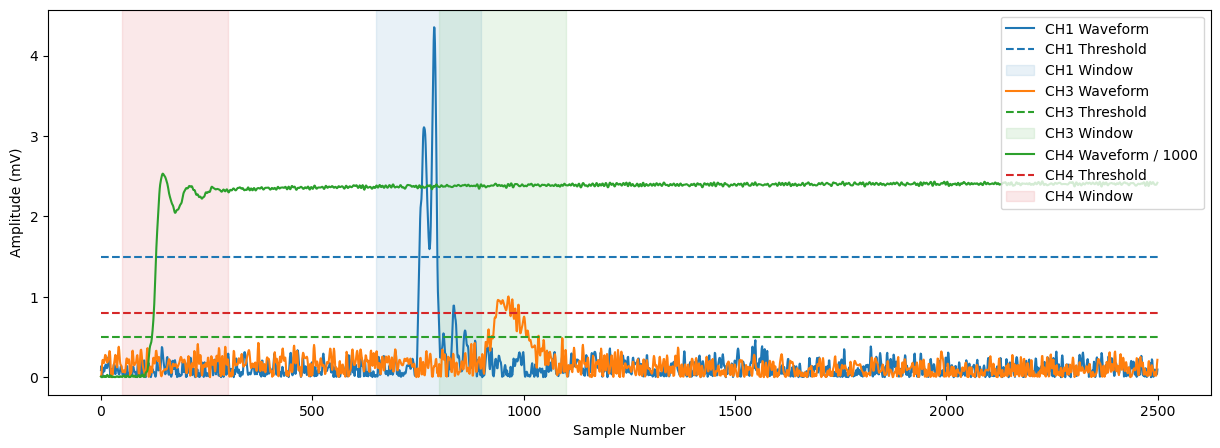

In [310]:
event_to_plot = 0

channels_to_plot = [1, 3, 4]
plt.figure(figsize=(15, 5))
for ch in channels_to_plot:
    # absolute threshold and window settings
    if ch == 1:
        threshold_disc = 1.5/1000  # volts
        window_min = 650
        window_max = 900
    elif ch == 2:
        threshold_disc = 0.5/1000  # volts
        window_min = 800
        window_max = 1100
    elif ch == 3:
        threshold_disc = 0.5/1000  # volts
        window_min = 800
        window_max = 1100
    elif ch == 4:
        threshold_disc = 0.8  # volts
        window_min = 50
        window_max = 300

    if ch == 4:
        # plt.plot(x_sample_times_ns, df2[f'CH{ch}_Waveform'][event_to_plot], label=f'CH{ch} Waveform')
        plt.plot(df2[f'CH{ch}_Waveform'][event_to_plot], label=f'CH{ch} Waveform / 1000')
    else:
        # plt.plot(x_sample_times_ns, df2[f'CH{ch}_Waveform'][event_to_plot]*1000, label=f'CH{ch} Waveform')
        plt.plot(df2[f'CH{ch}_Waveform'][event_to_plot]*1000, label=f'CH{ch} Waveform')

    # add threshold lines
    if ch == 4:
        plt.hlines(threshold_disc, 0, record_length, linestyles='dashed', label=f'CH{ch} Threshold', color='C'+str(ch-1))
    else:
        plt.hlines(threshold_disc*1000, 0, record_length, linestyles='dashed', label=f'CH{ch} Threshold', color='C'+str(ch-1))

    # add window areas
    plt.axvspan(window_min, window_max, color='C'+str(ch-1), alpha=0.1, label=f'CH{ch} Window')

    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude (mV)')
    # set legend to upper right
    plt.legend(loc='upper right')

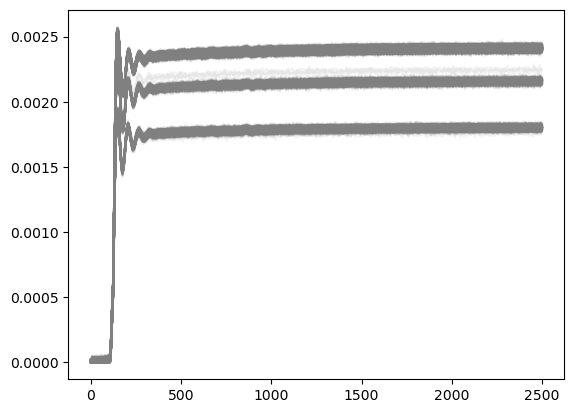

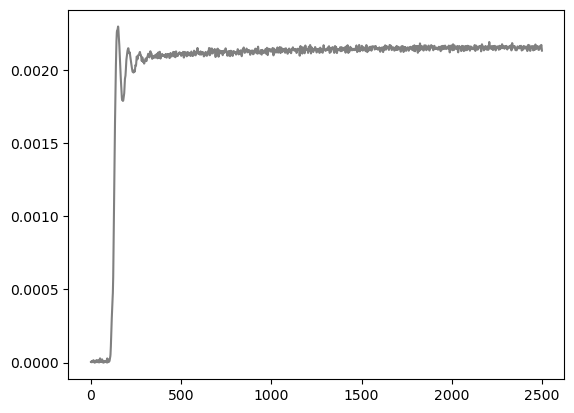

In [311]:
# plot 100 laser events (CH4) on top of each other
for i in range(1000):
    plt.plot(df2[f'CH4_Waveform'].iloc[i]/1000, color='gray', alpha=0.1)
plt.show()
plt.plot(df2[f'CH4_Waveform'].iloc[i]/1000, color='gray', alpha=1)


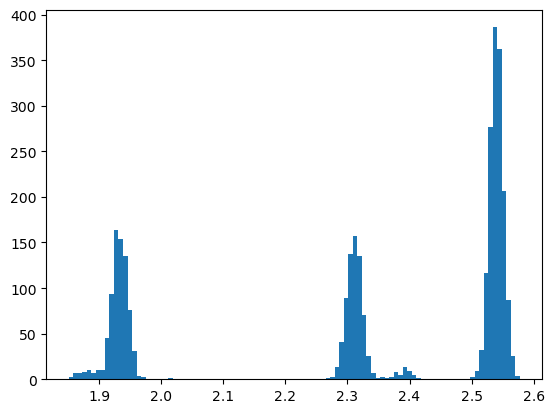

In [312]:
plt.hist(df2["CH4_Max"], bins=100, label='CH1 Max Distribution')

df2 = df2[df2["CH4_Max"] > 2.45].copy()


Cut at 0.016, keeping 1189/1507 events


(1.0, 200.0)

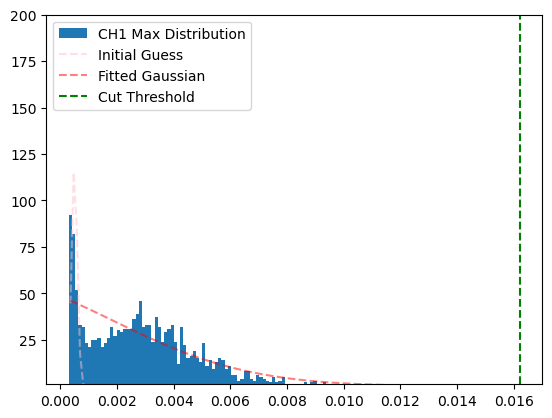

In [313]:
plt.hist(df2["CH1_Max"], bins=100, label='CH1 Max Distribution')

def gaussian(x, mu, std, A):
    return A * np.exp(-(x - mu) ** 2 / (2 * std ** 2))

hist, bin_edges = np.histogram(df2["CH1_Max"], bins=100)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
guess = (0.0005,0.0001,120)

# plot the guess
plt.plot(bin_centers, gaussian(bin_centers, *guess), color='pink', alpha=0.5, ls='--', label='Initial Guess')

popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=guess)
plt.plot(bin_centers, gaussian(bin_centers, *popt), color='red', alpha=0.5, ls='--', label='Fitted Gaussian')

sigma_cut = 4 * popt[1]
plt.axvline(popt[0] + sigma_cut, color='green', ls='--', label='Cut Threshold')


cut_manual = 0.001
# df3 = df2[df2["CH1_Max"] > (popt[0] + sigma_cut)]
df3 = df2[df2["CH1_Max"] > cut_manual].copy()

print(f"Cut at {popt[0] + sigma_cut:.3f}, keeping {len(df3)}/{len(df2)} events")
plt.legend()
# plt.yscale('log')
plt.ylim(1, 200)


In [314]:
df3

,File,Event,SampleInterval,RecordLength,PosX,PosY,CH1_Min,CH1_Max,CH1_Baseline,CH1_Threshold,...,CH3_Time,CH3_DiscTime,CH3_Waveform,CH4_Min,CH4_Max,CH4_Baseline,CH4_Threshold,CH4_Time,CH4_DiscTime,CH4_Waveform
0,MCP_Pulse__ALL_20251007092217379.csv,0,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.004352,0.059010,0.002176,...,918.522667,914,"[1.5187499999999996e-05, 3.3562499999999996e-0...",0.000281,2.531297,-0.008953,1.265648,133.572548,124,"[0.008, 0.0002812499999999985, 0.0046562499999..."
2,MCP_Pulse__ALL_20251007092217456.csv,2,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.003106,0.058884,0.001553,...,918.371150,911,"[0.0001298125, 7.575e-05, 7.375000000000003e-0...",0.000297,2.537172,-0.018187,1.268586,134.365638,125,"[0.01228125, 0.009468750000000001, 0.001031250..."
3,MCP_Pulse__ALL_20251007092217491.csv,3,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.003178,0.058848,0.001589,...,922.234990,922,"[1.956250000000002e-05, 6.050000000000001e-05,...",0.000078,2.548047,-0.013203,1.274023,134.701641,125,"[0.0023437500000000003, 0.008125, 0.0047656249..."
6,MCP_Pulse__ALL_20251007092217612.csv,6,4.000000e-11,2500,0.0,0.0,1.250000e-07,0.001050,0.058823,0.000525,...,916.061176,911,"[3.2999999999999935e-05, 1.2374999999999908e-0...",0.000953,2.549078,-0.022359,1.274539,134.788411,124,"[0.0023281250000000003, 0.0070156249999999976,..."
7,MCP_Pulse__ALL_20251007092217652.csv,7,4.000000e-11,2500,0.0,0.0,1.250000e-07,0.001911,0.058894,0.000956,...,921.357183,914,"[1.1500000000000008e-05, 1.9937500000000017e-0...",0.000187,2.539109,-0.001688,1.269555,134.063650,125,"[0.01784375, 0.0014375, 0.008875000000000001, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,MCP_Pulse__ALL_20251007092807357.csv,2980,4.000000e-11,2500,0.0,0.0,6.938894e-18,0.005668,0.059003,0.002834,...,920.890787,924,"[0.0001435, 0.0001335, 0.000142875, 0.00015974...",0.000141,2.540297,-0.016547,1.270148,134.324521,125,"[0.004671874999999999, 0.0007968750000000024, ..."
2983,MCP_Pulse__ALL_20251007092807985.csv,2983,4.000000e-11,2500,0.0,0.0,0.000000e+00,0.003588,0.058837,0.001794,...,921.800000,918,"[5.3437500000000045e-05, 2.8125000000000047e-0...",0.000016,2.547875,-0.012641,1.273937,134.015854,125,"[0.018843750000000003, 0.005406250000000001, 0..."
2988,MCP_Pulse__ALL_20251007092809185.csv,2988,4.000000e-11,2500,0.0,0.0,2.500000e-07,0.003045,0.058809,0.001522,...,909.948846,912,"[0.00011962499999999997, 0.0001149375, 0.00010...",0.000281,2.540812,-0.020188,1.270406,134.551848,125,"[0.0004375000000000004, 0.002859375000000001, ..."
2994,MCP_Pulse__ALL_20251007092810404.csv,2994,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.006264,0.058829,0.003132,...,919.082300,900,"[7.181249999999999e-05, 6.806249999999998e-05,...",0.000750,2.550812,-0.031594,1.275406,135.035593,124,"[0.002296874999999997, 0.007156250000000003, 0..."


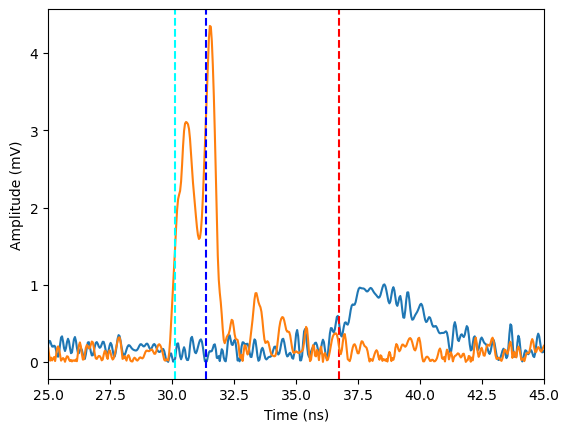

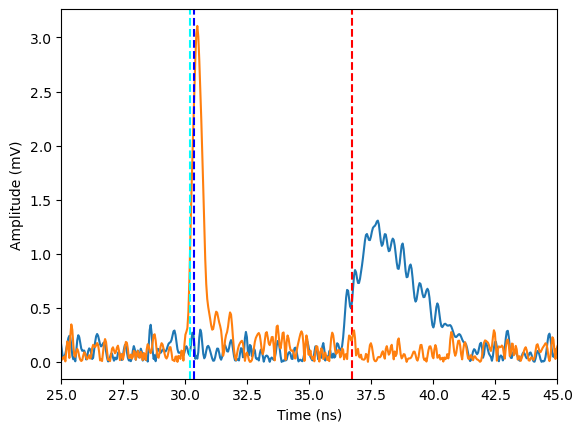

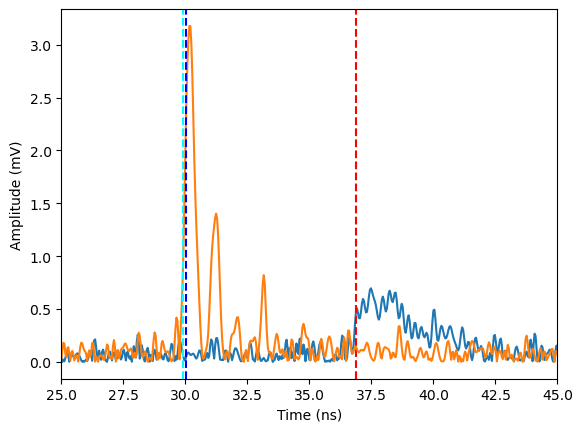

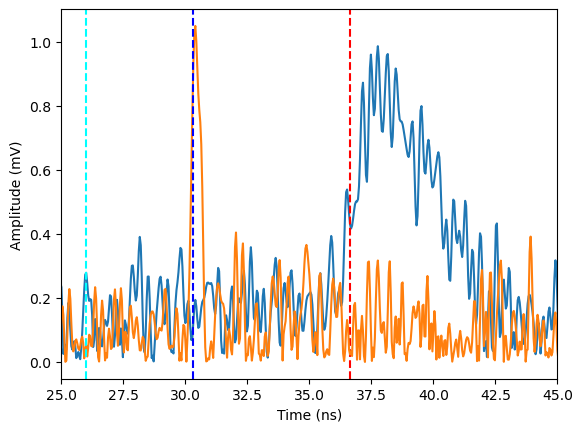

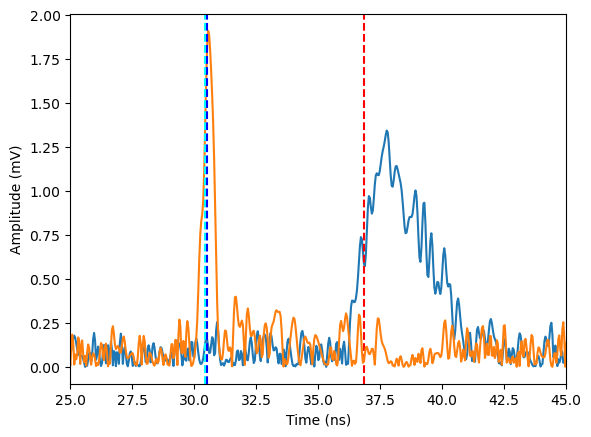

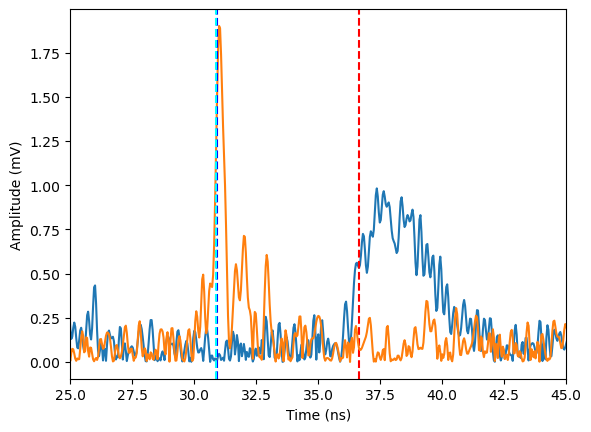

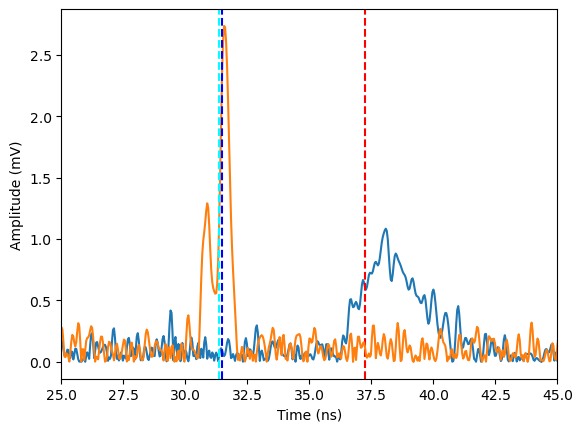

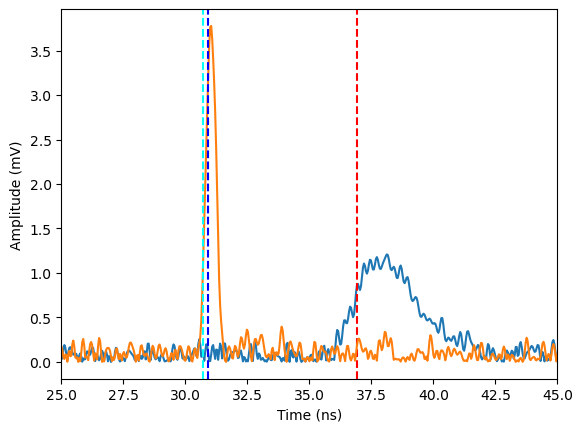

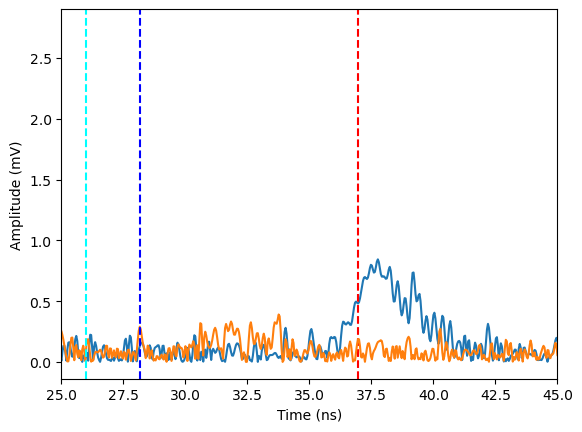

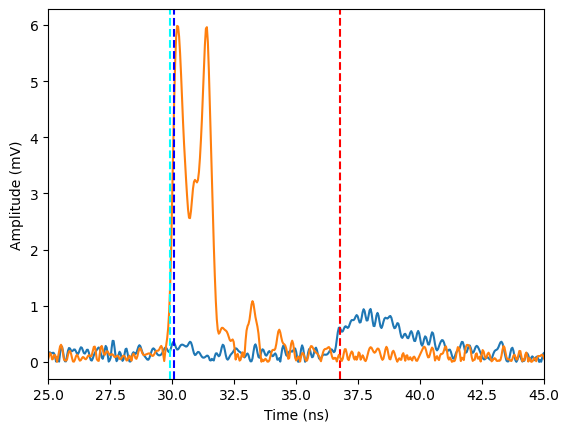

In [315]:
# plot the first 2000 entries of Channel 1
for i in range(10):
    plt.plot(x_sample_times_ns, df3["CH3_Waveform"].iloc[i]*1000)
    # mark the "time" point
    time_ch3 = df3["CH3_Time"].iloc[i] * sample_interval * 1e9  # in ns
    plt.axvline(time_ch3, color='red', ls='--', label='CH3 Time')
    plt.plot(x_sample_times_ns, df3["CH1_Waveform"].iloc[i]*1000)
    time_ch1 = df3["CH1_Time"].iloc[i] * sample_interval * 1e9  # in ns
    plt.axvline(time_ch1, color='blue', ls='--', label='CH1 Time')
    disc_time_c1 = df3["CH1_DiscTime"].iloc[i] * sample_interval * 1e9  # in ns
    plt.axvline(disc_time_c1, color='cyan', ls='--', label='CH1 Disc Time')
    plt.axvline()
    # plt.plot(x_sample_times_ns, df3["CH4_Waveform"].iloc[i])
    plt.xlabel('Time (ns)')
    plt.ylabel('Amplitude (mV)')
    plt.xlim(25,45)
    plt.show()

# save

(array([595.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        594.]),
 array([4.96  , 4.9604, 4.9608, 4.9612, 4.9616, 4.962 , 4.9624, 4.9628,
        4.9632, 4.9636, 4.964 , 4.9644, 4.9648, 4.9652, 4.9656, 4.966 ,
        4.9664, 4.9668, 4.9672, 4.9676, 4.968 , 4.9684, 4.9688, 4.9692,
        4.9696, 4.97  , 4.9704, 4.9708, 4.9712, 4.9716, 4.972 , 4.9724,
        4.9728, 4.9732, 4.9736

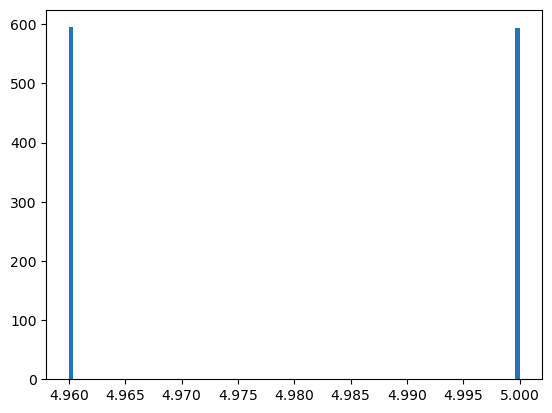

In [316]:
plt.hist(df3["CH4_DiscTime"]*sample_interval*1e9, bins=100, label='CH4 Disc Time Distribution')



In [317]:
df3["coinc_time"] = df3["CH3_Time"] - df3["CH1_Time"]
df3["coinc_time_ns"] = df3["coinc_time"] * sample_interval * 1e9  # in ns
df3["coinc_time_disc"] = (df3["CH3_DiscTime"] - df3["CH1_DiscTime"]) * sample_interval * 1e9  # in ns
df3

,File,Event,SampleInterval,RecordLength,PosX,PosY,CH1_Min,CH1_Max,CH1_Baseline,CH1_Threshold,...,CH4_Min,CH4_Max,CH4_Baseline,CH4_Threshold,CH4_Time,CH4_DiscTime,CH4_Waveform,coinc_time,coinc_time_ns,coinc_time_disc
0,MCP_Pulse__ALL_20251007092217379.csv,0,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.004352,0.059010,0.002176,...,0.000281,2.531297,-0.008953,1.265648,133.572548,124,"[0.008, 0.0002812499999999985, 0.0046562499999...",134.193835,5.367753,6.44
2,MCP_Pulse__ALL_20251007092217456.csv,2,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.003106,0.058884,0.001553,...,0.000297,2.537172,-0.018187,1.268586,134.365638,125,"[0.01228125, 0.009468750000000001, 0.001031250...",159.589851,6.383594,6.24
3,MCP_Pulse__ALL_20251007092217491.csv,3,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.003178,0.058848,0.001589,...,0.000078,2.548047,-0.013203,1.274023,134.701641,125,"[0.0023437500000000003, 0.008125, 0.0047656249...",171.207697,6.848308,6.96
6,MCP_Pulse__ALL_20251007092217612.csv,6,4.000000e-11,2500,0.0,0.0,1.250000e-07,0.001050,0.058823,0.000525,...,0.000953,2.549078,-0.022359,1.274539,134.788411,124,"[0.0023281250000000003, 0.0070156249999999976,...",158.707444,6.348298,10.44
7,MCP_Pulse__ALL_20251007092217652.csv,7,4.000000e-11,2500,0.0,0.0,1.250000e-07,0.001911,0.058894,0.000956,...,0.000187,2.539109,-0.001688,1.269555,134.063650,125,"[0.01784375, 0.0014375, 0.008875000000000001, ...",159.014826,6.360593,6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,MCP_Pulse__ALL_20251007092807357.csv,2980,4.000000e-11,2500,0.0,0.0,6.938894e-18,0.005668,0.059003,0.002834,...,0.000141,2.540297,-0.016547,1.270148,134.324521,125,"[0.004671874999999999, 0.0007968750000000024, ...",157.139195,6.285568,6.68
2983,MCP_Pulse__ALL_20251007092807985.csv,2983,4.000000e-11,2500,0.0,0.0,0.000000e+00,0.003588,0.058837,0.001794,...,0.000016,2.547875,-0.012641,1.273937,134.015854,125,"[0.018843750000000003, 0.005406250000000001, 0...",144.091260,5.763650,5.80
2988,MCP_Pulse__ALL_20251007092809185.csv,2988,4.000000e-11,2500,0.0,0.0,2.500000e-07,0.003045,0.058809,0.001522,...,0.000281,2.540812,-0.020188,1.270406,134.551848,125,"[0.0004375000000000004, 0.002859375000000001, ...",139.109269,5.564371,6.00
2994,MCP_Pulse__ALL_20251007092810404.csv,2994,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.006264,0.058829,0.003132,...,0.000750,2.550812,-0.031594,1.275406,135.035593,124,"[0.002296874999999997, 0.007156250000000003, 0...",142.279885,5.691195,5.56


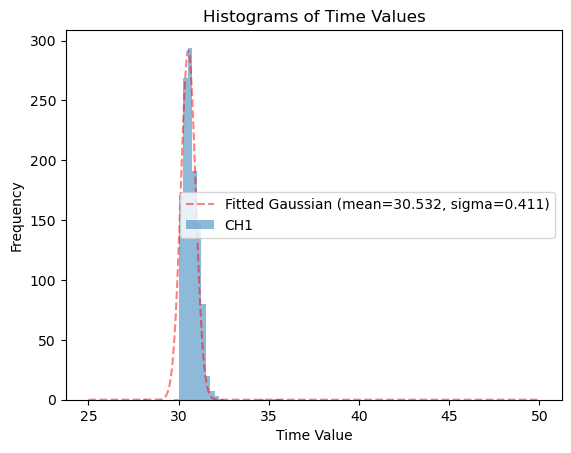

In [318]:
# plt.hist(df3["CH1_Time"], bins=100, alpha=0.5, label='CH1_Time')
# plt.hist(df2["CH2_Time"], bins=100, alpha=0.5, label='CH2_Time')

time_fitguess = (30.5, 0.1, 500)
fit_min, fit_max = 25.0, 50
# plot initial guess
bins = 100

def gaussian(x, mu, std, A):
    return A * np.exp(-(x - mu) ** 2 / (2 * std ** 2))

# plt.plot(np.linspace(fit_min, fit_max, 100), gaussian(np.linspace(fit_min, fit_max, 100), *time_fitguess), color='pink', alpha=0.5, ls='--', label='Initial Guess')

bin_centers = np.linspace(fit_min, fit_max, bins)
hist, bin_edges = np.histogram(df3["CH1_Time"]*sample_interval*1e9, bins=bins, range=(fit_min, fit_max))

popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=time_fitguess)
x_fit = np.linspace(fit_min, fit_max, 1000)
plt.plot(x_fit, gaussian(x_fit, *popt), color='red', alpha=0.5, ls='--', label='Fitted Gaussian (mean={:.3f}, sigma={:.3f})'.format(popt[0], abs(popt[1])))

plt.hist(df3["CH1_Time"]*sample_interval*1e9, bins=bins, alpha=0.5, label='CH1', range=(fit_min, fit_max))
plt.title("Histograms of Time Values")
plt.xlabel("Time Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

C:\Users\agche\AppData\Local\Temp\ipykernel_26012\2098928121.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=time_fitguess)


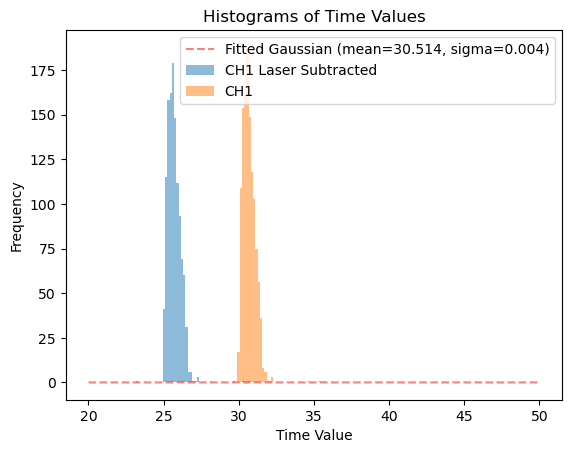

In [319]:
df3["CH1_Time_c"] = df3["CH1_Time"] - df3["CH4_DiscTime"]
df3["CH3_Time_c"] = df3["CH3_Time"] - df3["CH4_DiscTime"]



time_fitguess = (30.5, 0.1, 500)
fit_min, fit_max = 20.0, 50
# plot initial guess
bins = 200

def gaussian(x, mu, std, A):
    return A * np.exp(-(x - mu) ** 2 / (2 * std ** 2))

# plt.plot(np.linspace(fit_min, fit_max, 100), gaussian(np.linspace(fit_min, fit_max, 100), *time_fitguess), color='pink', alpha=0.5, ls='--', label='Initial Guess')

bin_centers = np.linspace(fit_min, fit_max, bins)
hist, bin_edges = np.histogram(df3["CH1_Time_c"]*sample_interval*1e9, bins=bins, range=(fit_min, fit_max))

popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=time_fitguess)
x_fit = np.linspace(fit_min, fit_max, 1000)
plt.plot(x_fit, gaussian(x_fit, *popt), color='red', alpha=0.5, ls='--', label='Fitted Gaussian (mean={:.3f}, sigma={:.3f})'.format(popt[0], abs(popt[1])))

plt.hist(df3["CH1_Time_c"]*sample_interval*1e9, bins=bins, alpha=0.5, label='CH1 Laser Subtracted', range=(fit_min, fit_max))
plt.hist(df3["CH1_Time"]*sample_interval*1e9, bins=bins, alpha=0.5, label='CH1', range=(fit_min, fit_max))
plt.title("Histograms of Time Values")
plt.xlabel("Time Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

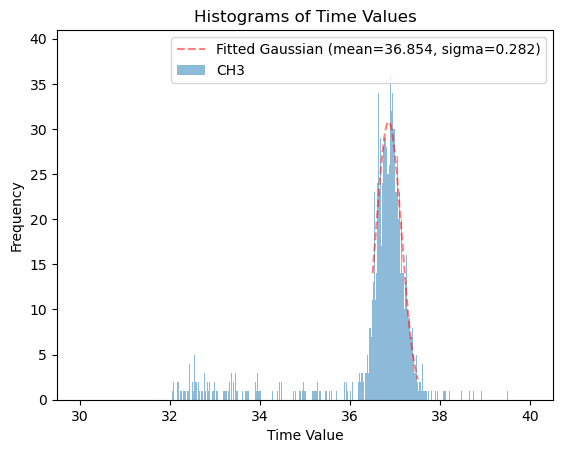

In [320]:
# plt.hist(df3["CH1_Time"], bins=100, alpha=0.5, label='CH1_Time')
# plt.hist(df2["CH2_Time"], bins=100, alpha=0.5, label='CH2_Time')

time_fitguess = (37.5, 0.1, 500)
fit_min, fit_max = 36.5,37.5
# plot initial guess
bins = 50

def gaussian(x, mu, std, A):
    return A * np.exp(-(x - mu) ** 2 / (2 * std ** 2))

# plt.plot(np.linspace(fit_min, fit_max, 100), gaussian(np.linspace(fit_min, fit_max, 100), *time_fitguess), color='pink', alpha=0.5, ls='--', label='Initial Guess')

bin_centers = np.linspace(fit_min, fit_max, bins)
hist, bin_edges = np.histogram(df3["CH3_Time"]*sample_interval*1e9, bins=bins, range=(fit_min, fit_max))

popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=time_fitguess)
x_fit = np.linspace(fit_min, fit_max, 1000)
plt.plot(x_fit, gaussian(x_fit, *popt), color='red', alpha=0.5, ls='--', label='Fitted Gaussian (mean={:.3f}, sigma={:.3f})'.format(popt[0], abs(popt[1])))

plt.hist(df3["CH3_Time"]*sample_interval*1e9, bins=bins*10, alpha=0.5, label='CH3', range=(30, 40))
plt.title("Histograms of Time Values")
plt.xlabel("Time Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

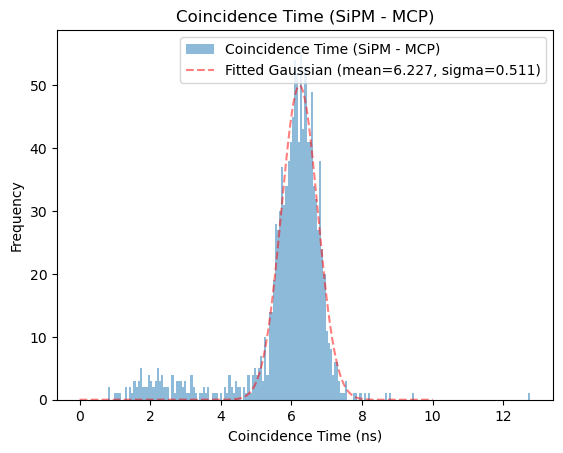

In [321]:
hist, bin_edges, _ = plt.hist(df3["coinc_time_ns"], bins=200, alpha=0.5, label='Coincidence Time (SiPM - MCP)')

# Calculate bin centers from bin edges
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# fit with a gaussian
coin_guess = (6.0, 0.5, 150)
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=coin_guess)
x_fit = np.linspace(0, 10, 1000)

plt.plot(x_fit, gaussian(x_fit, *popt), color='red', alpha=0.5, ls='--', label='Fitted Gaussian (mean={:.3f}, sigma={:.3f})'.format(popt[0], abs(popt[1])))
plt.title("Coincidence Time (SiPM - MCP)")
plt.xlabel("Coincidence Time (ns)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

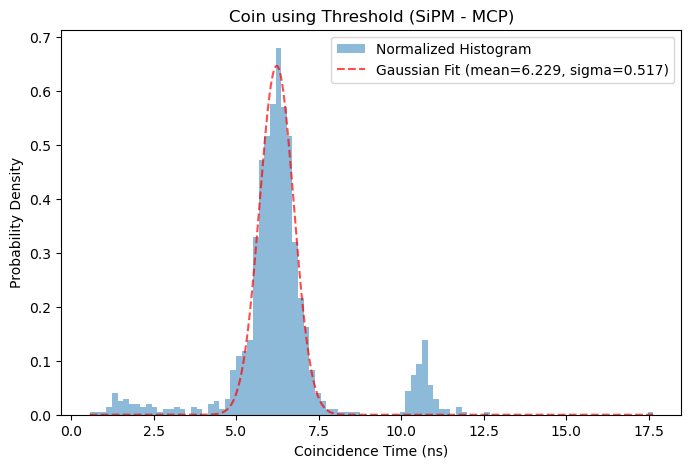

In [322]:
# Compute histogram with normalization
hist, bin_edges = np.histogram(df3["coinc_time_disc"], bins=150, density=True)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit the Gaussian to the normalized histogram
coin_guess = (6.0, 0.5, 0.5)  # Adjust amplitude guess (since density=True, amplitude ~ 1/(sigma*sqrt(2*pi)))
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=coin_guess)

# Generate fit curve
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 1000)
plt.figure(figsize=(8,5))

# Plot normalized histogram
plt.hist(df3["coinc_time_disc"], bins=100, density=True, alpha=0.5, label='Normalized Histogram')

# Plot fitted Gaussian
plt.plot(x_fit, gaussian(x_fit, *popt), color='red', alpha=0.7, ls='--',
         label=f'Gaussian Fit (mean={popt[0]:.3f}, sigma={abs(popt[1]):.3f})')

plt.title("Coin using Threshold (SiPM - MCP)")
plt.xlabel("Coincidence Time (ns)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()


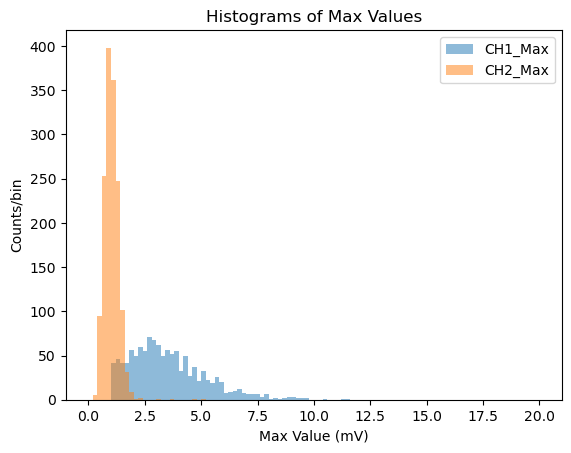

In [323]:
plt.hist(df3["CH1_Max"] * 1000, bins=100, alpha=0.5, label='CH1_Max', range=(0,20))
plt.hist(df2["CH3_Max"] * 1000, bins=100, alpha=0.5, label='CH2_Max', range=(0,20))
plt.title("Histograms of Max Values")
plt.xlabel("Max Value (mV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.show()

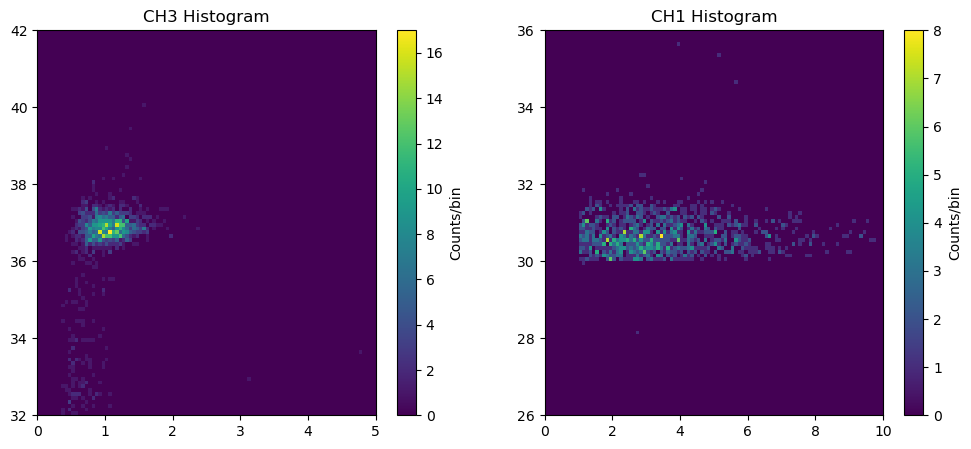

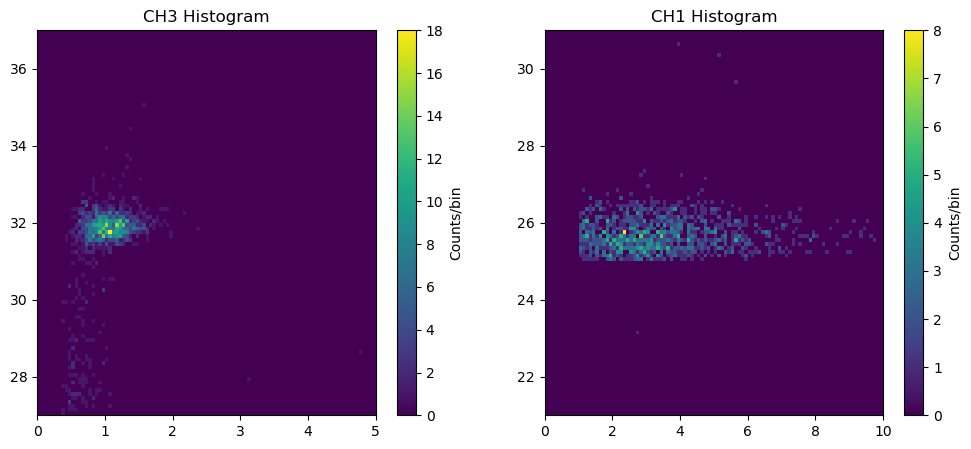

In [324]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist2d(df3["CH3_Max"]*1000, df3["CH3_Time"]*sample_interval*1e9, bins=100, cmap='viridis', range=[[0,5],[32, 42]])
plt.colorbar(label='Counts/bin')
plt.title('CH3 Histogram')
plt.subplot(1,2,2)
plt.hist2d(df3["CH1_Max"]*1000, df3["CH1_Time"]*sample_interval*1e9, bins=100, cmap='viridis', range=[[0,10],[26, 36]])
plt.colorbar(label='Counts/bin')
plt.title('CH1 Histogram')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist2d(df3["CH3_Max"]*1000, df3["CH3_Time_c"]*sample_interval*1e9, bins=100, cmap='viridis', range=[[0,5],[27, 37]])
plt.colorbar(label='Counts/bin')
plt.title('CH3 Histogram')
plt.subplot(1,2,2)
plt.hist2d(df3["CH1_Max"]*1000, df3["CH1_Time_c"]*sample_interval*1e9, bins=100, cmap='viridis', range=[[0,10],[21, 31]])
plt.colorbar(label='Counts/bin')
plt.title('CH1 Histogram')

plt.show()

In [325]:
df3

,File,Event,SampleInterval,RecordLength,PosX,PosY,CH1_Min,CH1_Max,CH1_Baseline,CH1_Threshold,...,CH4_Baseline,CH4_Threshold,CH4_Time,CH4_DiscTime,CH4_Waveform,coinc_time,coinc_time_ns,coinc_time_disc,CH1_Time_c,CH3_Time_c
0,MCP_Pulse__ALL_20251007092217379.csv,0,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.004352,0.059010,0.002176,...,-0.008953,1.265648,133.572548,124,"[0.008, 0.0002812499999999985, 0.0046562499999...",134.193835,5.367753,6.44,660.328831,794.522667
2,MCP_Pulse__ALL_20251007092217456.csv,2,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.003106,0.058884,0.001553,...,-0.018187,1.268586,134.365638,125,"[0.01228125, 0.009468750000000001, 0.001031250...",159.589851,6.383594,6.24,633.781299,793.371150
3,MCP_Pulse__ALL_20251007092217491.csv,3,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.003178,0.058848,0.001589,...,-0.013203,1.274023,134.701641,125,"[0.0023437500000000003, 0.008125, 0.0047656249...",171.207697,6.848308,6.96,626.027293,797.234990
6,MCP_Pulse__ALL_20251007092217612.csv,6,4.000000e-11,2500,0.0,0.0,1.250000e-07,0.001050,0.058823,0.000525,...,-0.022359,1.274539,134.788411,124,"[0.0023281250000000003, 0.0070156249999999976,...",158.707444,6.348298,10.44,633.353732,792.061176
7,MCP_Pulse__ALL_20251007092217652.csv,7,4.000000e-11,2500,0.0,0.0,1.250000e-07,0.001911,0.058894,0.000956,...,-0.001688,1.269555,134.063650,125,"[0.01784375, 0.0014375, 0.008875000000000001, ...",159.014826,6.360593,6.12,637.342357,796.357183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,MCP_Pulse__ALL_20251007092807357.csv,2980,4.000000e-11,2500,0.0,0.0,6.938894e-18,0.005668,0.059003,0.002834,...,-0.016547,1.270148,134.324521,125,"[0.004671874999999999, 0.0007968750000000024, ...",157.139195,6.285568,6.68,638.751592,795.890787
2983,MCP_Pulse__ALL_20251007092807985.csv,2983,4.000000e-11,2500,0.0,0.0,0.000000e+00,0.003588,0.058837,0.001794,...,-0.012641,1.273937,134.015854,125,"[0.018843750000000003, 0.005406250000000001, 0...",144.091260,5.763650,5.80,652.708740,796.800000
2988,MCP_Pulse__ALL_20251007092809185.csv,2988,4.000000e-11,2500,0.0,0.0,2.500000e-07,0.003045,0.058809,0.001522,...,-0.020188,1.270406,134.551848,125,"[0.0004375000000000004, 0.002859375000000001, ...",139.109269,5.564371,6.00,645.839577,784.948846
2994,MCP_Pulse__ALL_20251007092810404.csv,2994,4.000000e-11,2500,0.0,0.0,6.250000e-08,0.006264,0.058829,0.003132,...,-0.031594,1.275406,135.035593,124,"[0.002296874999999997, 0.007156250000000003, 0...",142.279885,5.691195,5.56,652.802416,795.082300


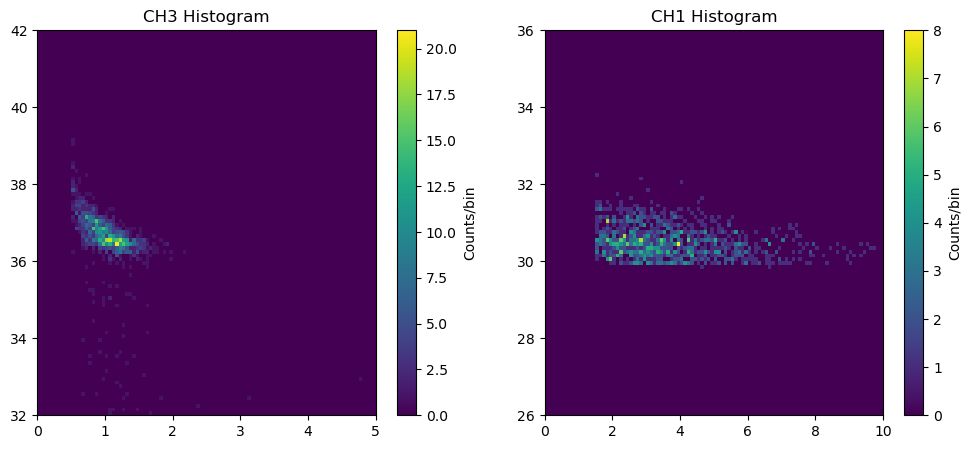

In [326]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist2d(df3["CH3_Max"]*1000, df3["CH3_DiscTime"]*sample_interval*1e9, bins=100, cmap='viridis', range=[[0,5],[32, 42]])
plt.colorbar(label='Counts/bin')
plt.title('CH3 Histogram')
plt.subplot(1,2,2)
plt.hist2d(df3["CH1_Max"]*1000, df3["CH1_DiscTime"]*sample_interval*1e9, bins=100, cmap='viridis', range=[[0,10],[26, 36]])
plt.colorbar(label='Counts/bin')
plt.title('CH1 Histogram')

plt.show()